# LSTM - Binary

In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Layer
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import asarray
from numpy import zeros
from keras.regularizers import L2
import tensorflow.keras.backend as K
import tensorflow as tf


### Dataset Loading and Splitting

Loading the dataset with more preprocessing steps.  We will call it Dataset 1.

In [2]:
df_train1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/train_tweets_LSTM_pre_new_binary.csv')
df_val1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/eval_tweets_LSTM_pre_new_binary.csv')
df_test1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/test_tweets_LSTM_p_new_binary.csv')

df_train1 = df_train1.sample(frac=1).reset_index(drop=True)
df_val1 = df_val1.sample(frac=1).reset_index(drop=True)
df_test1 = df_test1.sample(frac=1).reset_index(drop=True)

X_train1, y_train1 = df_train1["tweet_text"], df_train1["cyberbullying_type"]
X_val1, y_val1 = df_val1["tweet_text"], df_val1["cyberbullying_type"]
X_test1, y_test1 = df_test1["tweet_text"], df_test1["cyberbullying_type"]

Loading the dataset with less preprocessing steps.
We will call it Dataset 2.

In [3]:
df_train2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/train_tweets_LSTM_no_new_binary.csv')
df_val2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/eval_tweets_LSTM_no_new_binary.csv')
df_test2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/test_tweets_LSTM_no_new_binary.csv')

df_train2 = df_train2.sample(frac=1).reset_index(drop=True)
df_val2 = df_val2.sample(frac=1).reset_index(drop=True)
df_test2 = df_test2.sample(frac=1).reset_index(drop=True)

X_train2, y_train2 = df_train2["tweet_text"], df_train2["cyberbullying_type"]
X_val2, y_val2 = df_val2["tweet_text"], df_val2["cyberbullying_type"]
X_test2, y_test2 = df_test2["tweet_text"], df_test2["cyberbullying_type"]

Investigating tweets length distribution of different datasets.

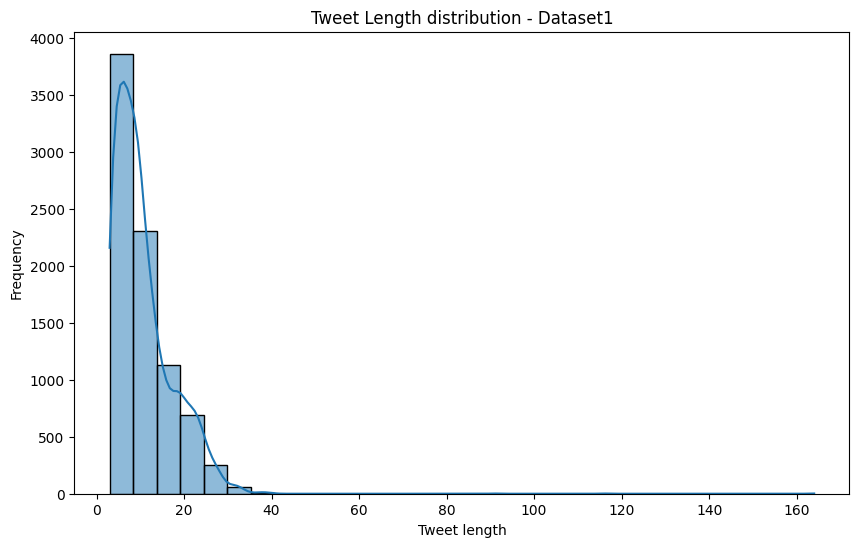

Percentage of tweets longer than 45 tokens: 0.04%


In [4]:
df_train1['tweet_length'] = df_train1['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train1['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution - Dataset1')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

df_train1['text_len'] = [len(text.split()) for text in df_train1.tweet_text]
max_len = 45
count = (df_train1['text_len'] >= max_len).sum() 
total_tweets = len(df_train1)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

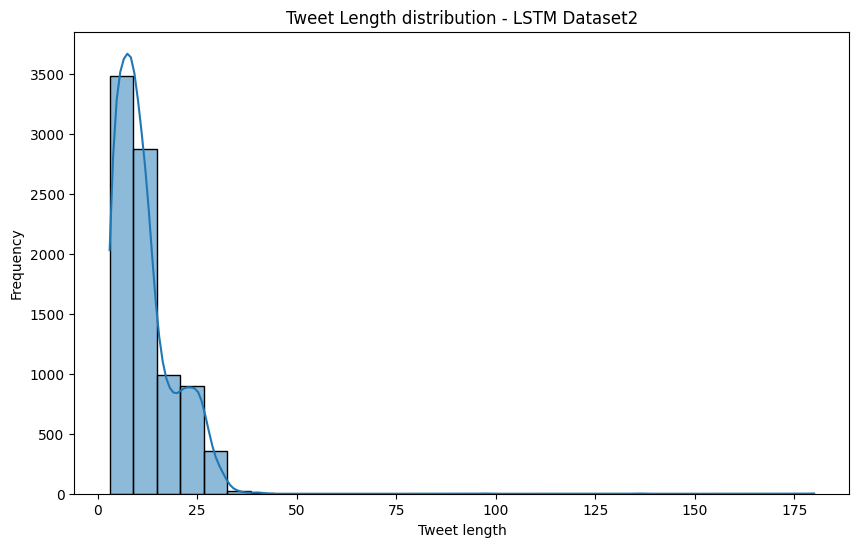

Percentage of tweets longer than 45 tokens: 0.03%


In [5]:
df_train2['tweet_length'] = df_train2['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train2['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution - LSTM Dataset2')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

df_train2['text_len'] = [len(text.split()) for text in df_train2.tweet_text]
max_len = 45
count = (df_train2['text_len'] >= max_len).sum() 
total_tweets = len(df_train2)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

The distribution of tweet lengths appears to be quite consistent, with most tweets falling between 5 and 30 tokens. Consequently, we established a threshold of 45 tokens, truncating tweets longer than this limit and padding those that are shorter. It's interesting to note that Dataset 2, despite having fewer preprocessing steps, contains fewer tweets exceeding the established threshold. This discrepancy could arise because one of the additional preprocessing steps we applied involved correcting misspelled words in English

### Embeddings

We dediced to try different techniques to create our embedding: GloVe 200 dimensions, GloVe 50 dimensions and FastText.

In [6]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y_train1 = label_encoder.fit_transform(y_train1)
y_val1 = label_encoder.transform(y_val1)
y_test1 = label_encoder.transform(y_test1)

#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer1 = Tokenizer()
word_tokenizer1.fit_on_texts(X_train1)

X_train1 = word_tokenizer1.texts_to_sequences(X_train1)
X_test1 = word_tokenizer1.texts_to_sequences(X_test1)
X_val1 = word_tokenizer1.texts_to_sequences(X_val1)

vocab_length1 = len(word_tokenizer1.word_index) + 1

print("The vocaboulary length for Dataset 1 is:", vocab_length1)

X_train1 = pad_sequences(X_train1, padding = 'pre', maxlen = max_len)
X_test1 = pad_sequences(X_test1, padding = 'pre', maxlen = max_len)
X_val1 = pad_sequences(X_val1, padding = 'pre', maxlen = max_len)

The vocaboulary length for Dataset 1 is: 10176


In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y_train2 = label_encoder.fit_transform(y_train2)
y_val2 = label_encoder.transform(y_val2)
y_test2 = label_encoder.transform(y_test2)

#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer2 = Tokenizer()
word_tokenizer2.fit_on_texts(X_train2)

X_train2 = word_tokenizer2.texts_to_sequences(X_train2)
X_test2 = word_tokenizer2.texts_to_sequences(X_test2)
X_val2 = word_tokenizer2.texts_to_sequences(X_val2)

vocab_length2 = len(word_tokenizer2.word_index) + 1

print("The vocaboulary length for Dataset 2 is:", vocab_length2)

X_train2 = pad_sequences(X_train2, padding = 'pre', maxlen = max_len)
X_test2 = pad_sequences(X_test2, padding = 'pre', maxlen = max_len)
X_val2 = pad_sequences(X_val2, padding = 'pre', maxlen = max_len)

The vocaboulary length for Dataset 2 is: 17473


We observe that the vocabulary length of Dataset 2 is larger. This is expected, as the dataset has undergone fewer preprocessing steps.

Depending on how we want to create our embeddings, we run one of the following cells.

### Glove

In [10]:
def glove(vocab_length, dim, word_tokenizer):
    # Load GloVe word embeddings and create a dictionary that willl contain words as keys, and their corresponging embedding list as values. 
    embeddings_dictionary = dict()
    glove_file = open(f'Embeddings/glove.twitter.27B.{dim}d.txt', encoding="utf8") ## ATTENTION: change if you change emebdding dim

    for line in glove_file:

        records = line.split()
        word = records[0]

        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

    glove_file.close()

    embedding_matrix = zeros((vocab_length, dim)) ## ATTENTION: change if the dim of embedding changes above

    i = 0
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)

        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            i = i + 1

    print("The number of out-of-vocabulary words is:", i)
    print("The percentage of out-of-vocabulary words is:", (i/vocab_length) * 100 )
    print()
    
    return embedding_matrix

In [12]:
print('Embedding matrix 200 dim Dataset 1:')
emb_matrix1_200 = glove(vocab_length1, 200, word_tokenizer1)

print('Embedding matrix 50 dim Dataset 1:')
emb_matrix1_50 = glove(vocab_length1, 50, word_tokenizer1)

print('Embedding matrix 200 dim Dataset 2:')
emb_matrix2_200 = glove(vocab_length2, 200, word_tokenizer2)

print('Embedding matrix 50 dim Dataset 2:')
emb_matrix1_50 = glove(vocab_length2, 50, word_tokenizer2)

Embedding matrix 200 dim Dataset 1:
The number of out-of-vocabulary words is: 396
The percentage of out-of-vocabulary words is: 3.891509433962264

Embedding matrix 50 dim Dataset 1:
The number of out-of-vocabulary words is: 396
The percentage of out-of-vocabulary words is: 3.891509433962264

Embedding matrix 200 dim Dataset 2:
The number of out-of-vocabulary words is: 2467
The percentage of out-of-vocabulary words is: 14.118926343501403

Embedding matrix 50 dim Dataset 2:
The number of out-of-vocabulary words is: 2467
The percentage of out-of-vocabulary words is: 14.118926343501403



The number of out-of-vocabulary words in the two datasets is very different: 3.8% for dataset 1 and 14.1% for dataset 2. One reason is certainly that dataset 1 is smaller; additionally, it has undergone more preprocessing steps.

### Fasttext

In [11]:
#Load embedding matrix 
embedding_matrix1 = np.load("Embeddings/BIN_fasttext_embeddingmatrix_pre.npy") 

embedding_matrix2 = np.load("Embeddings/BIN_fasttext_embeddingmatrix_no.npy")

To successfully run the grid search part, we have to set as embedding_matrix the matrix we want to use. For example, in this case we will use emb_matrix2_200. 

In [13]:
embedding_matrix = emb_matrix2_200 

We also have to set the dataset we want to use (1 or 2), and vocab_length (1 or 2). In this case, we will obviously use dataset 2.

In [14]:
X_train = X_train2
y_train = y_train2
X_val = X_val2
y_val = y_val2
X_test = X_test2
y_test = y_test2
vocab_length = vocab_length2

In [15]:
# Just checking everything is working properly
print(X_train[1])
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  163   38 7316 1233
  823   47 3722]
X_train shape: (8635, 45)
y_train shape: (8635,)
X_val shape: (2201, 45)
y_val shape: (2201,)
X_test shape: (2674, 45)
y_test shape: (2674,)


## LSTM - baseline

### Model Creation 

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable= False, #Depending on which embeddings we use
                        mask_zero = True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=False,
    directory='BIN_trial_rs', # Specify folder name
    project_name='trial_baseline_rs' # Specify folder name
)

# EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=100, 
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## LSTM - Bidirectional 

### Model Creation

In [127]:
def build_model_bi(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=False, # ATTENZIONE: Depending on which embeddings we use
                        mask_zero=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model_bi,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1, 
    overwrite=True,
    directory='BIN_trial_rs', 
    project_name='trial_bidirectional_rs' 
)

# Callback di EarlyStopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=100, 
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## LSTM - Attention

### Attention Layer

In [19]:
@tf.keras.utils.register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, name=None, trainable=True, dtype=None, **kwargs):
        super(AttentionLayer, self).__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)

    def build(self, input_shape):
        # input_shape = (sequence_length, features)
        # Define the shape of the weights = (features, 1)
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal',
                                 trainable=True)

        # Define the shape of the bias (sequence_length, 1) 
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[-2], 1),
                                initializer='zeros',
                                trainable=True)
        
        super(AttentionLayer, self).build(input_shape)

    def call(self, x, mask=None, **kwargs):
        # x is the input tensor with shape: (batch_size, sequence_length, features)
        # Compute the attention scores, which should have shape (sequence_length, 1)
        attention_scores = K.dot(x, self.W)  # Shape: (sequence_length, 1)
        # Adding the bias
        attention_scores += self.b
        # Applying tanh activation to the attention scores
        attention_scores = K.tanh(attention_scores)
        
        if mask is not None:
            # Use the mask to zero-out padding in the softmax computation
            mask = K.cast(mask, K.floatx())  # Convert mask to float
            mask = K.expand_dims(mask, axis=-1)  # Make mask shape match attention_scores
            attention_scores += (mask - 1) * 1e9  # Apply a large negative to mask-out areas

        # Applying softmax to get attention weights across the sequence dimension
        attention_weights = K.softmax(attention_scores, axis=1)

        # Multiply each value by the corresponding attention weights (broadcasting)
        weighted_input = x * attention_weights

        # Summing over the sequence length to get the context vector
        context_vector = K.sum(weighted_input, axis=1)

        return context_vector

    def compute_output_shape(self, input_shape):
        # The output of the layer is a context vector for each example
        # with the dimensionality equal to the feature size of the input.
        return (input_shape[0], input_shape[-1])

    def compute_mask(self, inputs, mask=None):
        # Return None because no need to pass the mask to subsequent layers
        return None
    
    def get_config(self):
        # This method should return the config dictionary with all the parameters needed to recreate the layer
        config = super(AttentionLayer, self).get_config()
        return config


### Model Creation

In [20]:
def build_model_att(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=False, # Depending on which embeddings we use
                        mask_zero = True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01), return_sequences=True))
    model.add(AttentionLayer())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model_att,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=True,
    directory='BIN_attention_nodense_rs',
    project_name='pre_200_rs' 
)

# Callback di EarlyStopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=100,
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## Model Training

As suggested on the Keras official documentation, we re-train the model using the best parameters found. This was done for all models, after each grid search. 

To try this code, you need to choose one of the model configuration above (baseline, bidirectional or attention), run the model creation and grid search cells, and then run this code. 

In [ ]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hp.
best_model = build_model(best_hps[0]) # ATTENTION: change according to the model you want to create: build_model = baseline, build_model_bi = bidirectional, build_model_att = attention

# Model training
history = best_model.fit(x = X_train, y = y_train, 
                         epochs=50,
                         validation_data = [X_val, y_val],
                         callbacks = [callback],
                         batch_size=fixed_batch_size)

# Saving the model 
best_model.save('BIN_model.h5') 

In [ ]:
# Loss and accuracy plots for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model Assessment

The next step consisted in checking the model's performance.

In [ ]:
# Loading the model
model = tf.keras.models.load_model('BIN_model.h5')

# If the model has an attention layer, run the following line and not the previous
# model = tf.keras.models.load_model('best_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [ ]:
# Just checking everything is good
model.summary() 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
y_pred = model.predict(X_test2)
y_pred_classes =(y_pred > 0.5).astype(int)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Model comparison

The research we conducted was extensive, as we tested various model combinations by varying the type of embedding, text preprocessing methods, and model configurations. In the next section, we will present the key insights and considerations we find most relevant based on the results obtained from all the models analyzed.

In the case of the binary problem, the performance of the models does not seem to change significantly depending on the dataset and, therefore, on the data preprocessing. For example, between both models—LSTM bidirectional with 50-dimensional embeddings from datasets 1 and 2—we can notice that they perform similarly. However, the model from dataset 2 shows a slight performance advantage.

In [135]:
model1 = tf.keras.models.load_model('Models/LSTM/BIN_pre_bidi_50.h5')

model2 = tf.keras.models.load_model('Models/LSTM/BIN_no_bidi_50.h5')


In [136]:
test_loss, test_accuracy = model1.evaluate(X_test1, y_test1)

print(f'Test Loss Model 1: {test_loss}')
print(f'Test Accuracy Model 1: {test_accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8226 - loss: 0.4397
Test Loss Model 1: 0.4194875657558441
Test Accuracy Model 1: 0.8339565992355347


In [137]:
test_loss, test_accuracy = model2.evaluate(X_test2, y_test2)

print(f'Test Loss Model 2: {test_loss}')
print(f'Test Accuracy Model 2: {test_accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8197 - loss: 0.4245
Test Loss Model 2: 0.3939928114414215
Test Accuracy Model 2: 0.8391922116279602


Model 1 - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1338
           1       0.85      0.81      0.83      1336

    accuracy                           0.83      2674
   macro avg       0.83      0.83      0.83      2674
weighted avg       0.83      0.83      0.83      2674

Class Names:  [0 1]


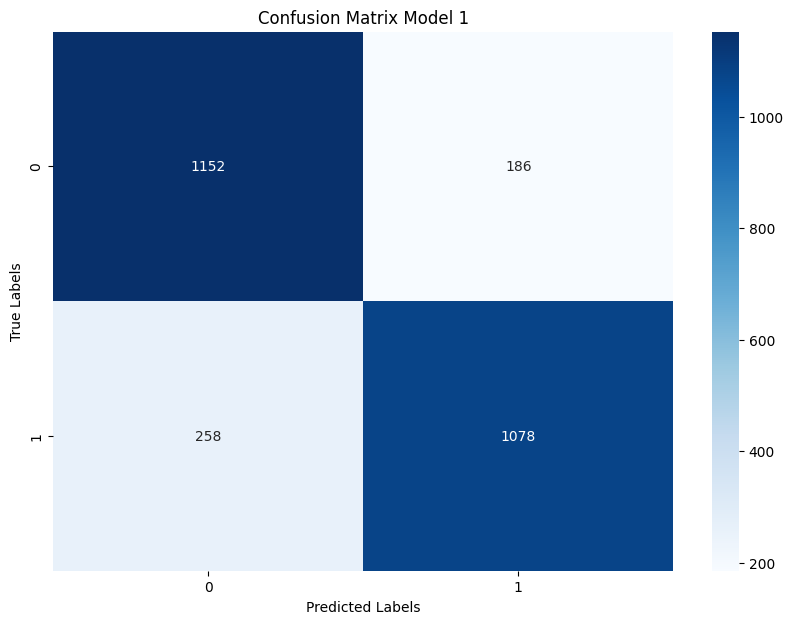

In [138]:
print('Model 1 - Classification Report')
y_pred = model1.predict(X_test1)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 1')
plt.show()

Model 2 - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1338
           1       0.85      0.82      0.84      1336

    accuracy                           0.84      2674
   macro avg       0.84      0.84      0.84      2674
weighted avg       0.84      0.84      0.84      2674

Class Names:  [0 1]


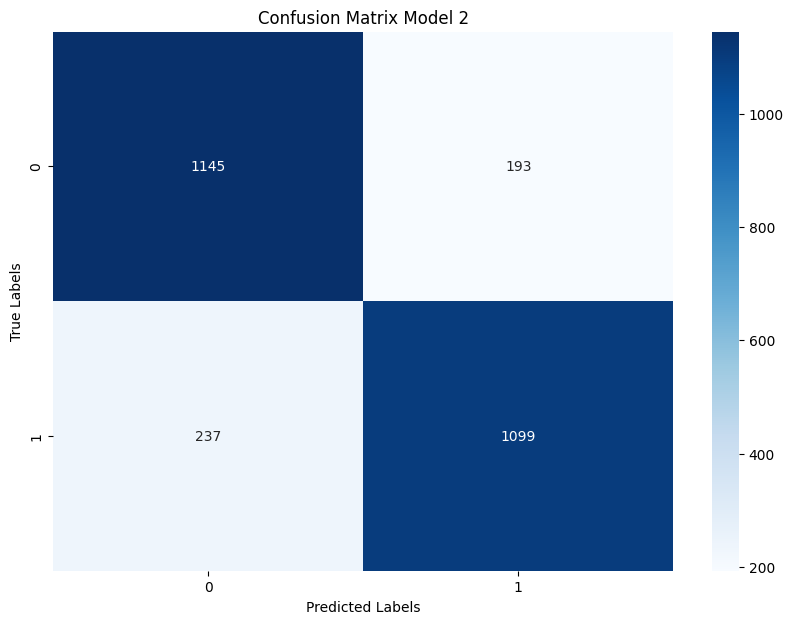

In [139]:
print('Model 2 - Classification Report')
y_pred = model2.predict(X_test2)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 2')
plt.show()

The second consideration we make concerns the LSTM models from dataset 1, which perform worse with FastText 100-dimensional embeddings. This does not happen with dataset 2, possibly because dataset 2 has a slightly larger vocabulary due to less preprocessing. Let's take, for example, the baseline LSTM model trained on dataset 1 with 100-dimensional FastText embeddings.

In [28]:
model1 = tf.keras.models.load_model('Models/LSTM/BIN_pre_base_100.h5')

In [29]:
test_loss, test_accuracy = model1.evaluate(X_test1, y_test1)

print(f'Test Loss Model 1: {test_loss}')
print(f'Test Accuracy Model 1: {test_accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7610 - loss: 0.4985
Test Loss Model 1: 0.4933664798736572
Test Accuracy Model 1: 0.7759910225868225


Model 1 - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1338
           1       0.86      0.66      0.75      1336

    accuracy                           0.78      2674
   macro avg       0.79      0.78      0.77      2674
weighted avg       0.79      0.78      0.77      2674

Class Names:  [0 1]


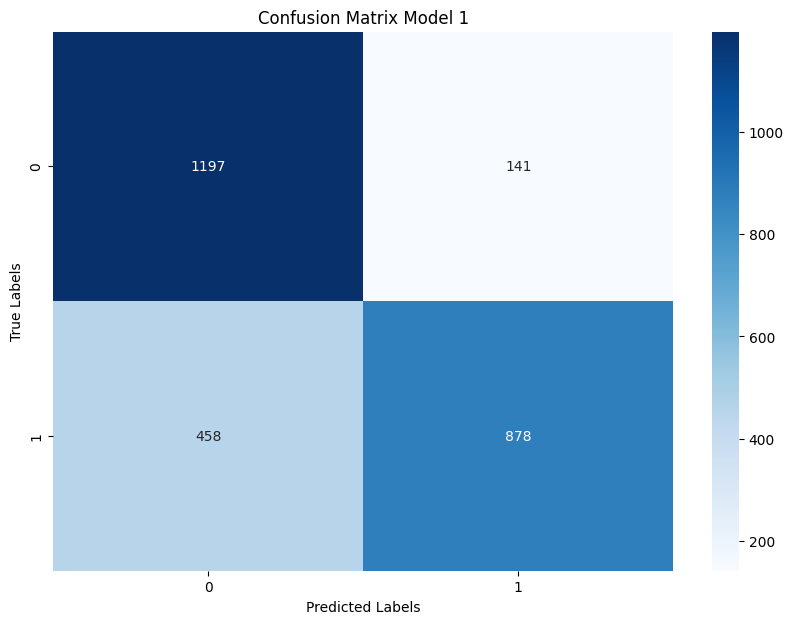

In [30]:
print('Model 1 - Classification Report')
y_pred = model1.predict(X_test1)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 1')
plt.show()

Additionally, there are no significant differences between different architectures. For instance, consider the models trained with dataset 2 and 50-dimensional embeddings.

In [31]:
model1 = tf.keras.models.load_model('Models/LSTM/BIN_no_base_50.h5')
model2 =  tf.keras.models.load_model('Models/LSTM/BIN_no_bidi_50.h5')
model3 = tf.keras.models.load_model('Models/LSTM/BIN_no_att_50.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [32]:
test_loss, test_accuracy = model1.evaluate(X_test2, y_test2)
print(f'Test Loss Model 200: {test_loss}')
print(f'Test Accuracy Model 200: {test_accuracy}')
print()

test_loss, test_accuracy = model2.evaluate(X_test2, y_test2)
print(f'Test Loss Model 50: {test_loss}')
print(f'Test Accuracy Model 50: {test_accuracy}')
print()

test_loss, test_accuracy = model3.evaluate(X_test2, y_test2)
print(f'Test Loss Model 100: {test_loss}')
print(f'Test Accuracy Model 100: {test_accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8485 - loss: 0.3743
Test Loss Model 200: 0.3882260024547577
Test Accuracy Model 200: 0.8436799049377441

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8493 - loss: 0.3764
Test Loss Model 50: 0.39210572838783264
Test Accuracy Model 50: 0.8429319262504578

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8580 - loss: 0.3562
Test Loss Model 100: 0.3643608093261719
Test Accuracy Model 100: 0.8597606420516968


Baseline - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1338
           1       0.85      0.83      0.84      1336

    accuracy                           0.84      2674
   macro avg       0.84      0.84      0.84      2674
weighted avg       0.84      0.84      0.84      2674

Class Names:  [0 1]


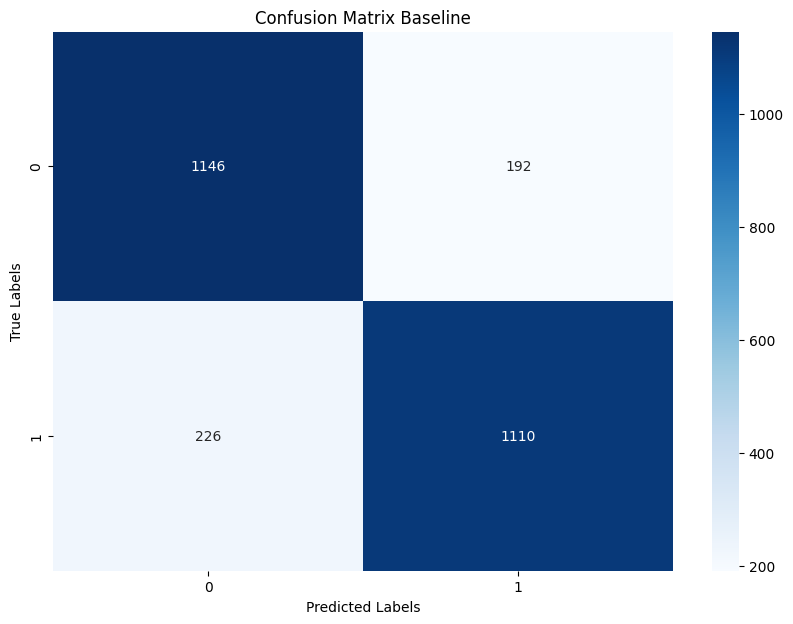

In [33]:
print('Baseline - Classification Report')
y_pred = model1.predict(X_test2)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Baseline')
plt.show()

Bidirectional - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1338
           1       0.86      0.82      0.84      1336

    accuracy                           0.84      2674
   macro avg       0.84      0.84      0.84      2674
weighted avg       0.84      0.84      0.84      2674

Class Names:  [0 1]


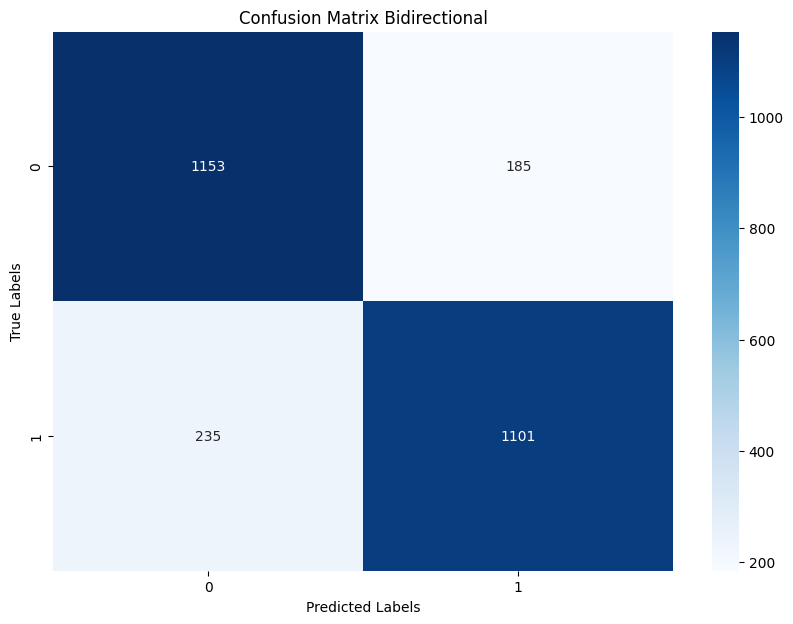

In [34]:
print('Bidirectional - Classification Report')
y_pred = model2.predict(X_test2)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Bidirectional')
plt.show()

Attention - Classification Report
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1338
           1       0.87      0.84      0.86      1336

    accuracy                           0.86      2674
   macro avg       0.86      0.86      0.86      2674
weighted avg       0.86      0.86      0.86      2674

Class Names:  [0 1]


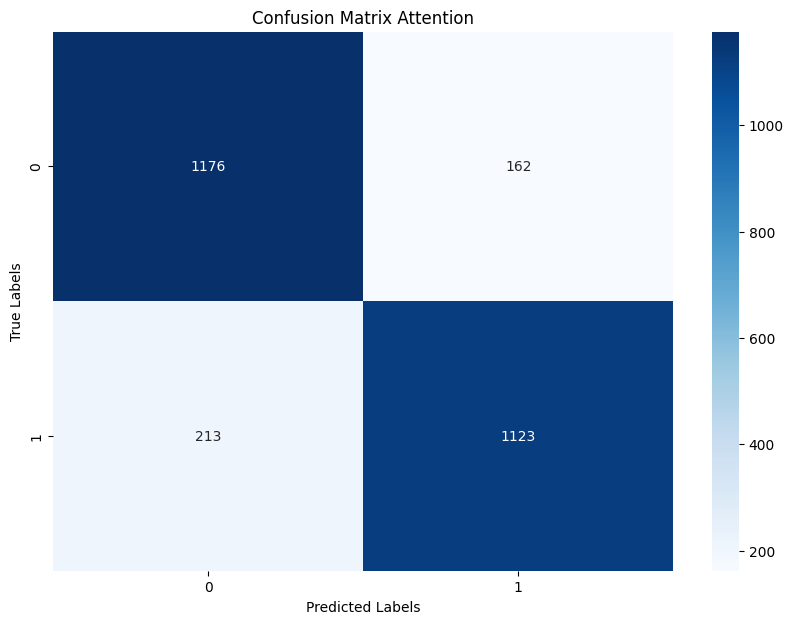

In [35]:
print('Attention - Classification Report')
y_pred = model3.predict(X_test2)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Attention')
plt.show()